In [1]:
import numpy as np
import scipy as sp

import matplotlib as mpl
import matplotlib.pyplot as plt

# **** #
PI = sp.constants.pi
C = 1  # natural units
HBAR = sp.constants.hbar  # units need to be changed
ME = sp.constants.physical_constants["electron mass energy equivalent in MeV"][0]*1000  # keV(/c^2)
MP = sp.constants.physical_constants["proton mass energy equivalent in MeV"][0]*1000  # keV(/c^2)
rng = np.random.default_rng()

# **** #
source = ("sodium", "cesium", "cobalt", "lyso")[0]
source_energy = {"sodium":511, "cesium":662, "cobalt":140}[source]  # keV

# **** #
eg = source_energy # keV
ege = eg*0.1 # what is this value actually?
eg2 = 1275#2*source_energy#

ideal_min_scat_eg = eg/(1 + eg/(ME*C*C)*2)

# **** #
print(f"{source=}")
print(f"{source_energy=}")
print(f"{eg=}")
print(f"{ege=}")
print(f"{eg2=}")

print(f"Minimum once scattered E: {ideal_min_scat_eg:.0f} ({ideal_min_scat_eg/eg:.2f})")

source='sodium'
source_energy=511
eg=511
ege=51.1
eg2=1275
Minimum once scattered E: 170 (0.33)


In [2]:
import ROOT

gc = [] # ROOT garbage collector

DATA_DIR = "/home/psimmerl/module_testing/data/from_alex_june1"

mid = "100090"
nspe, nsrc = 10000, 100000
fname = f"module_{mid}_Vov3.00_Nspe{nspe}_N{source}{nsrc}.root"

ch = 9
print(f"{DATA_DIR=}")
print(f"{fname=}")
print(f"{ch=}")
print("")

tfile = ROOT.TFile(f"{DATA_DIR}/{fname}")
hdata = tfile.Get(f"{source}_ch{ch}")

x_data = np.array([hdata.GetBinCenter(i) for i in range(1, hdata.GetNbinsX())])
y_data = np.array([hdata.GetBinContent(i) for i in range(1, hdata.GetNbinsX())])

print(f"N Entries = {sum(y_data):,.0f}")
print(f"N Bins = {len(x_data)}")
print(f"X Range = ({x_data.min():.2f}, {x_data.max():.2f})")
print("")

# find offset using pedestal (does tony do this already?)
x_offset = 0 # x_data.min()

# # find the peak position
# mask_peak = y_data > np.max(y_data) - 3*np.sqrt(np.max(y_data))
# x_peak = ((y_data*(x_data-x_offset))[mask_peak]/y_data[mask_peak].sum()).sum()

# x2e = lambda x: (x - x_offset)/x_peak * source_energy
# e2x = lambda e: e/source_energy * x_peak + x_offset

# e_std = (y_data[mask_peak]/y_data[mask_peak].sum() * (x2e(x_data[mask_peak])-source_energy)**2).sum()**0.5
# print(f"Setting {ege=:.4f} to ege={e_std:.4f}")
# ege = e_std

fit_data = tfile.Get(f"{source}_ch{ch}_fit")


x_peak = fit_data.GetParameter(0)*source_energy
x_std = fit_data.GetParameter(1)

x2e = lambda x: (x - x_offset)/(x_peak - x_offset) * source_energy
e2x = lambda e: e/source_energy * (x_peak - x_offset) + x_offset


print(f"Found peak at: {x_peak:.2f} +/- {x_std:.2f}")
# print(f"Setting {ege=:.4f} to ege={x_std*(source_energy**0.5):.4f}")
print(f"Setting {ege=:.4f} to ege={x_std * (source_energy/(x_peak - x_offset))**1.0:.4f}")
ege = x_std * (source_energy/(x_peak - x_offset))**1.0
# print(f"Setting {ege=:.4f} to ege={x_std * (source_energy/(x_peak - x_offset))**2.0:.4f}")
# ege = x_std * (source_energy/(x_peak - x_offset))**2.0
# print(f"Setting {ege=:.4f} to ege={x_std * (source_energy/(x_peak - x_offset))**0.5:.4f}")
# ege = x_std * (source_energy/(x_peak - x_offset))**0.5

e_data = x2e(x_data)

Welcome to JupyROOT 6.30/04
DATA_DIR='/home/psimmerl/module_testing/data/from_alex_june1'
fname='module_100090_Vov3.00_Nspe10000_Nsodium100000.root'
ch=9

N Entries = 13,150
N Bins = 136
X Range = (191.69, 1329.09)

Found peak at: 775.25 +/- 46.76
Setting ege=51.1000 to ege=30.8215


In [3]:
def scatter_gamma(eg, theta):
    return eg / ( 1 + (eg/(ME*C*C))*(1-np.cos(theta)) )

def scatter_gammas(eg, theta):
    return np.apply_along_axis(lambda _eg: scatter_gamma(_eg, theta), 0, eg)

def klein_nishina(eg, theta):
    es = scatter_gamma(eg, theta)
    re, me = 1, 511
    return 1/2 * re**2 * (es/eg)**2 * (es/eg + eg/es - np.sin(theta)**2)
    # return 1/2 * re**2 * (eg/es)**2 * (eg/es + es/eg - np.sin(theta)**2)

# def smear(energy, kernel=ege/np.sqrt(eg)):
#     return rng.normal(energy, kernel * np.sqrt(energy))
def smear(energy, kernel=ege):
    return rng.normal(energy, kernel)


In [4]:
# import vector
# me = 511
# eg = 511
# theta = 1
# eg_scat = scatter_gamma(eg, theta)
# e1 = vector.obj(px=0, py=0, pz=0, energy=me)
# g1 = vector.obj(px=0, py=0, pz=eg, energy=eg)
# g2 = vector.obj(px=0, py=eg_scat*np.sin(theta), theta=theta, energy=eg_scat)
# e2 = e1+g1-g2
# e1, g1, g2, e2, e2.E, e2.M

# # (E, px, py, pz)
# # e1 + g1 - g2 = (me+eg-eg_scat)

-1.0808340701671348 -0.5736373681225769


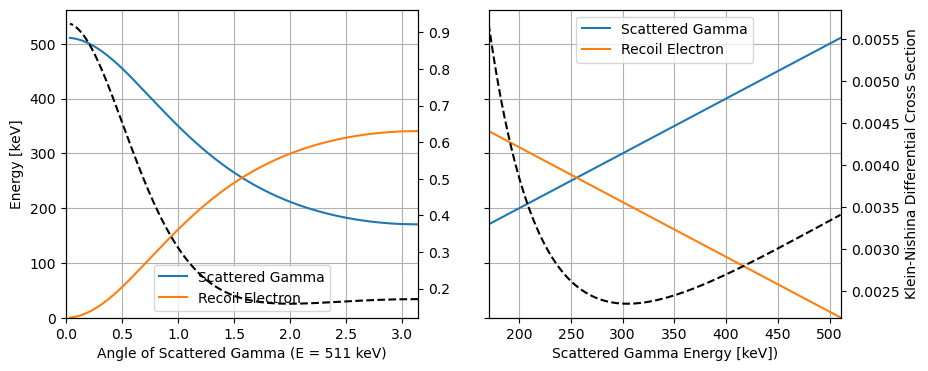

In [5]:
energy = np.linspace(eg/(1+2*eg/ME), eg, 1000, endpoint=False)
theta = np.arccos(1 - ME*(1/energy - 1/eg))

dtheta = -1 / (1 - (1 - ME*(1/energy-1/eg))**2)**0.5 * ME/energy**2
domega = np.sin(theta) * dtheta
domega[~np.isfinite(domega)] = 0
# domega = np.abs( domega )

kn_xs_t = klein_nishina(eg, theta)
kn_xs_e = kn_xs_t * domega
print(np.trapz(kn_xs_t, theta), np.trapz(kn_xs_e, energy))
kn_xs_t /= np.trapz(kn_xs_t, theta) * (-1 if theta[1] < theta[0] else 1) 
kn_xs_e /= np.trapz(kn_xs_e, energy) * (-1 if energy[1] < energy[0] else 1) 

eg_scat = scatter_gamma(eg, theta)
ee_scat = eg - eg_scat

fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)
# fig.tight_layout()

ax1, ax2 = axs[::-1]


ax2.plot(theta, eg_scat, label="Scattered Gamma")
ax2.plot(theta, ee_scat, label="Recoil Electron")

ax2.set_xlabel(f"Angle of Scattered Gamma (E = {eg:.0f} keV)")
ax2.set_ylabel("Energy [keV]")
ax2.set_xlim(0, PI)
ax2.set_ylim(0, eg*1.1)

ax2b = ax2.twinx()
ax2b.plot(theta, kn_xs_t, "k--")
# ax2b.set_ylabel("Klein-Nishina Differential Cross Section")

ax2.legend(loc="lower center")
ax2.grid()


ax1.plot(energy, eg_scat, label="Scattered Gamma")
ax1.plot(energy, ee_scat, label="Recoil Electron")

ax1.set_xlabel(f"Scattered Gamma Energy [keV])")
# ax1.set_ylabel("Energy [keV]")
ax1.set_xlim(eg/(1+2*eg/ME), eg)
ax1.set_ylim(0, eg*1.1)

ax1b = ax1.twinx()
ax1b.plot(energy, kn_xs_e, "k--")
ax1b.set_ylabel("Klein-Nishina Differential Cross Section")

ax1.legend(loc="upper center")
ax1.grid()

-138.79034371123043 1.1173457244131892


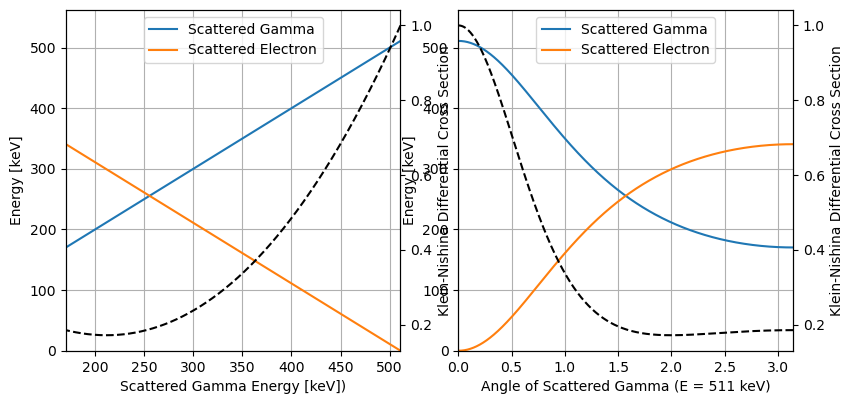

In [6]:
theta = np.linspace(0, PI, 1000)
energy = scatter_gamma(eg, theta)

kn_xs = klein_nishina(eg, theta)
print(np.trapz(kn_xs, energy), np.trapz(kn_xs, theta))

eg_scat = scatter_gamma(eg, theta)
ee_scat = eg - eg_scat

fig, axs = plt.subplots(1,2, figsize=(8,4))
fig.tight_layout()

ax1, ax2 = axs
ax1.plot(energy, eg_scat, label="Scattered Gamma")
ax1.plot(energy, ee_scat, label="Scattered Electron")

ax1.set_xlabel(f"Scattered Gamma Energy [keV])")
ax1.set_ylabel("Energy [keV]")
ax1.set_xlim(eg/(1+2*eg/ME), eg)
ax1.set_ylim(0, eg*1.1)

ax1b = ax1.twinx()
ax1b.plot(energy, kn_xs, "k--")
ax1b.set_ylabel("Klein-Nishina Differential Cross Section")

ax1.legend(loc="upper center")
ax1.grid()

ax2.plot(theta, eg_scat, label="Scattered Gamma")
ax2.plot(theta, ee_scat, label="Scattered Electron")

ax2.set_xlabel(f"Angle of Scattered Gamma (E = {eg:.0f} keV)")
ax2.set_ylabel("Energy [keV]")
ax2.set_xlim(0, PI)
ax2.set_ylim(0, eg*1.1)

ax2b = ax2.twinx()
ax2b.plot(theta, kn_xs, "k--")
ax2b.set_ylabel("Klein-Nishina Differential Cross Section")

ax2.legend(loc="upper center")
ax2.grid()

p0=0.04, p1=0.02, p2=0.04, p3=0.01, p4=0.04, p5=0.02, p6=14.49
p0=1.00, p1=0.53, p2=1.08, p3=0.38, p4=1.16, p5=0.53, p6=387.15

Chi2 = 611.857
Chi2/NDF = 4.707


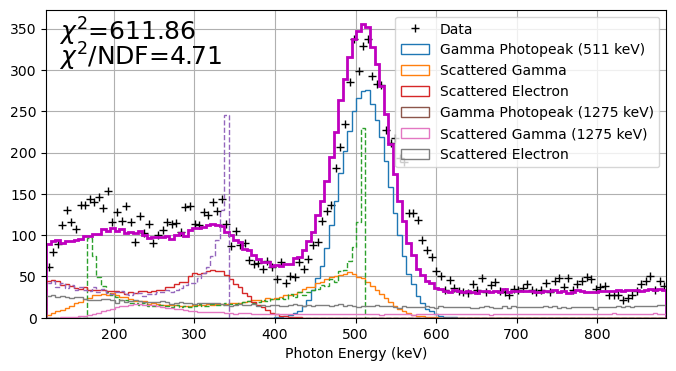

In [7]:
n = 100_000

ptheta = klein_nishina(eg, theta)
# ptheta = np.abs(np.sin(theta))
# ptheta = np.sin(theta)**2
# ptheta = np.abs(np.cos(theta))
# ptheta = np.cos(theta)**2
# ptheta = 1 / (1 + 2 * np.sin(theta/2)**2 )
ptheta /= ptheta.sum()

eg_gaus = smear(np.ones(n)*eg)
eg2_gaus = smear(np.ones(n)*eg2)

t = rng.choice(theta,len(eg_gaus),p=ptheta)
eg_scat1 = scatter_gamma(eg, t)
ee_scat1 = eg-eg_scat1
eg_scat1_smeared = smear(eg_scat1)
ee_scat1_smeared = smear(ee_scat1)

# eg_scat2_smeared = scatter_gamma(eg_scat1_smeared, rng.choice(theta,len(eg_gaus),p=ptheta))
# # eg_scat2_smeared = scatter_gamma(eg, rng.choice(theta,len(eg_gaus),p=ptheta))
# eg_scat2_smeared = rng.normal(eg_scat2_smeared, ege * (eg_scat2_smeared/eg))

# eg_scat3_smeared = scatter_gamma(eg_scat2_smeared, rng.choice(theta,len(eg_gaus),p=ptheta))
# # eg_scat3_smeared = scatter_gamma(eg, rng.choice(theta,len(eg_gaus),p=ptheta))
# eg_scat3_smeared = rng.normal(eg_scat3_smeared, ege * (eg_scat3_smeared/eg))

# eg2_scat1_smeared = scattered_egamma(eg2_gaus, rng.choice(theta,len(eg2_gaus),p=ptheta))
t = rng.choice(theta,len(eg2_gaus),p=ptheta)
eg2_scat1 = scatter_gamma(eg2, t)
ee2_scat1 = eg2-eg2_scat1
eg2_scat1_smeared = smear(eg2_scat1)
ee2_scat1_smeared = smear(ee2_scat1)

# eg2_scat2_smeared = scatter_gamma(eg2_scat1_smeared, rng.choice(theta,len(eg2_gaus),p=ptheta))
# # eg2_scat2_smeared = scatter_gamma(eg, rng.choice(theta,len(eg2_gaus),p=ptheta))
# eg2_scat2_smeared = rng.normal(eg2_scat2_smeared, ege * (eg2_scat2_smeared/eg))

####
def reweight(x, *args, return_all=False, match_data=False):
    args = np.asarray(args).flatten()

    # xo = args[-2]
    # # xo = args[-3]
    # # xp = args[-2]
    # sig = args[-1]
    # args = args[:-2]
    # # args = args[:-3]
    xo = args[-1]
    args = args[:-1]

    x2e = lambda _x: (_x - xo)/(x_peak - xo) * source_energy
    e2x = lambda _e: _e/source_energy * (x_peak - xo) + xo
    x = x2e(x)

    de = x[1] - x[0]
    
    all_data = np.stack([
        eg_gaus, # smear(np.ones(n)*eg,sig),
        eg_scat1_smeared, # smear(eg_scat1,sig),
        ee_scat1_smeared, # smear(ee_scat1,sig),
        eg2_gaus, # smear(np.ones(n)*eg2,sig),
        eg2_scat1_smeared, # smear(eg2_scat1,sig),
        ee2_scat1_smeared, # smear(ee2_scat1,sig),
        rng.uniform(x.min()-de/2, x.max()+de/2, len(eg_gaus)),
        # rng.exponential(args[-1], len(eg_gaus)),
    ])

    # if args:
    if len(args) == 5+1: # no 2nd photopeak
        args = [*args[:3], 0, *args[3:]]
    if len(args) == 4+1: # no 2nd photopeak, no 2nd electon
        args = [*args[:3], 0, args[3], 0, args[4]]
    if len(args) == 3+1: # no 2nd photopeak, no 2nd electron/compton
        args = [*args[:3], 0, 0, 0, args[3]]
    weights = np.array(args).reshape(-1,1)
    # else:
    #     weights = np.array([
    #         1,
    #         0.4,
    #         0.4,
    #         0.2,
    #         0.4,
    #         0.4,
    #     ]).reshape(-1,1)

    if match_data:
        mask_all = (e_data.min()-de/2 < all_data) & (all_data < e_data.max()+de/2)
        weights = weights * y_data.sum()/(weights*mask_all).sum()

    all_weight = np.ones_like(all_data) * weights

    e_weight = all_weight[0, :]
    eg_weight = all_weight[1, :]
    ee_weight = all_weight[2, :]

    e2_weight = all_weight[3, :]
    eg2_weight = all_weight[4, :]
    ee2_weight = all_weight[5, :]

    bkg_weight = all_weight[6, :]

    all_data, all_weight = all_data.flatten(), all_weight.flatten()
    if return_all:
        return all_data, all_weight, (
            e_weight,
            eg_weight,
            ee_weight,
            e2_weight,
            eg2_weight,
            ee2_weight,
            bkg_weight,
        )
    nx, dx = len(x), x[1]-x[0] 
    hist, bin_edges = np.histogram(all_data, bins=nx, range=(x.min()-de/2, x.max()+de/2), weights=all_weight)
    return hist

####

popt = [ # Na22, mid=100090, ch=9
    1, # 1,
    0.6, # 0.4,
    0.4, # 0.4,
    # 0, # 180.91, # 0.2,
    0.2, # 0.4,
    0.2, # 4.90, # 0.4,
    0, # uniform bkg
    0, # x offset
    # x_peak, # signal peak charge
    # ege, # detector sensitivity
]
data = x_data
u = sum(y_data)/n

popt, pcov = sp.optimize.curve_fit(
    reweight,
    data,
    y_data,
    p0=popt,#[p*u if p > u else p  for p in popt],
    sigma=np.sqrt(y_data),
    # bounds=(0, 50),
    # bounds=(0, (u, u, u, u, u, u, u, 100)),#2000, 200)),
    # bounds=(0, (u, u, u, u, u, u, 100)),#2000, 200)),
    # bounds=(0, (u, u, u, u, u, 100)),#2000, 200)),
    # bounds=(0, (u, u, u, u, 100)),#2000, 200)),
    # bounds=(0, (u, u, u, u, 100, 100)),#2000, 200)),
    # bounds=((0,0,0,0,0,ege/3), (u, u, u, u, 100, 500)),#2000, 200)),
    bounds=((0,0,0,0,0,0,0), (1,1,1,1,1,1,200)),#2000, 200)),
)
print(", ".join([f"p{i}={p:.2f}" for i, p in enumerate(popt)]))
print(", ".join([f"p{i}={p/popt[0]:.2f}" for i, p in enumerate(popt)]))
print("")
if popt[0] == 1:
    all_data, all_weight, weights = reweight(data, popt, return_all=True, match_data=True)
else:
    all_data, all_weight, weights = reweight(data, popt, return_all=True)

e_weight = weights[0]
eg_weight = weights[1]
ee_weight = weights[2]

e2_weight = weights[3]
eg2_weight = weights[4]
ee2_weight = weights[5]

# x_offset = popt[-2]
# sig = popt[-1]

x_offset = popt[-1]
x2e = lambda x: (x - x_offset)/(x_peak - x_offset) * source_energy
e2x = lambda e: e/source_energy * (x_peak - x_offset) + x_offset
e_data = x2e(x_data)

# eg_gaus = smear(np.ones(n)*eg,sig)
# eg_scat1_smeared = smear(eg_scat1,sig)
# ee_scat1_smeared = smear(ee_scat1,sig)
# eg2_gaus = smear(np.ones(n)*eg2,sig)
# eg2_scat1_smeared = smear(eg2_scat1,sig)
# ee2_scat1_smeared = smear(ee2_scat1,sig)

################################
fig, ax = plt.subplots(figsize=(8,4))
# b, r, density = 500, (0, 3*eg), False
de = e_data[1]-e_data[0]
# b, r, density = int(3*eg/de), (0, 3*eg), False
b, r, density = len(x_data), (e_data.min() - de/2, e_data.max() + de/2), False


####

ax.plot(e_data, y_data, "k+", label="Data")

values, be, _ = ax.hist(
    all_data,
    bins=b,
    range=r,
    weights=all_weight,
    density=density,
    histtype="step",
    label=None,#"All data",
    lw=2,
    color="m",
)

ndf = len(x_data) - sum(y_data==0) - (len(popt)+2)
ndf = len(x_data) - sum(y_data==0) - (len(popt)-1)

# chi2 = ( ((y_data - values))**2 ).sum()
# print(f"Chi2 = {chi2:.3f}")
# print(f"Chi2/NDF = {chi2 / ndf:.3f}")

chi2 = ( (y_data - values)**2/np.maximum(1,y_data) ).sum()
print(f"Chi2 = {chi2:.3f}")
print(f"Chi2/NDF = {chi2 / ndf:.3f}")

ax.text(0.02, 0.98, f"$\\chi^2$={chi2:.2f}", size=18, ha="left", va="top", transform=ax.transAxes)
ax.text(0.02, 0.90, f"$\\chi^2$/NDF={chi2/ndf:.2f}", size=18, ha="left", va="top", transform=ax.transAxes)

ax.hist(eg_gaus, weights=e_weight, bins=b, range=r, density=density, histtype="step", label="Gamma Photopeak (511 keV)")
ax.hist(eg_scat1_smeared, weights=eg_weight, bins=b, range=r, density=density, histtype="step", label="Scattered Gamma")
ax.hist(eg_scat1, weights=eg_weight, bins=b, range=r, density=density, histtype="step", linestyle="--")
ax.hist(ee_scat1_smeared, weights=ee_weight, bins=b, range=r, density=density, histtype="step", label="Scattered Electron")
ax.hist(ee_scat1, weights=ee_weight, bins=b, range=r, density=density, histtype="step", linestyle="--")

ax.hist(eg2_gaus, weights=e2_weight, bins=b, range=r, density=density, histtype="step", label="Gamma Photopeak (1275 keV)")
ax.hist(eg2_scat1_smeared, weights=eg2_weight, bins=b, range=r, density=density, histtype="step", label="Scattered Gamma (1275 keV)")
ax.hist(ee2_scat1_smeared, weights=ee2_weight, bins=b, range=r, density=density, histtype="step", label="Scattered Electron")

ax.set_xlabel("Photon Energy (keV)")
ax.set_ylabel("probability" if density else None)#"count")
ax.set_xlim(r)

# ax.yscale("log")
ax.legend(loc="upper right")
ax.grid()


In [8]:
# from ROOT import TCanvas, TF1, TF1Convolution

# kn_str = "(({1}/(1+2*{1}/511) < {0}) && ({0} < {1})) * abs(-TMath::Pi()*511/({1}*{1}) * (2*511/{1} + 511*511/({1}*{1}) + ({0})/{1} + ({1}-2*511*(1+511/{1}))/({0}) + 511*511/(({0})*({0}))))"
# spectra = "[2]*TMath::Exp(-((x-[1])/[0])*((x-[1])/[0])/2)) / ([0] * TMath::Sqrt(2*TMath::Pi()))" \
#     + " + [3]*" + kn_str.format("x/[1]*511",511) \
#     + " + [4]*" + kn_str.format("511 - x/[1]*511",511) \
#     + " + [5]*" + kn_str.format("x/[1]*511",1275) \
#     + " + [6]*" + kn_str.format("511 - x/[1]*511",1275)
#  # ([1] == x)" \
# response = "TMath::Exp(-(x/[0])*(x/[0])/2)) / ([0] * TMath::Sqrt(2*TMath::Pi()))"
# # response = "gausn(x, 0, 30)"# [0])"

# xmin = hdata.GetBinCenter(hdata.FindFirstBinAbove()+10)
# xmax = hdata.GetBinCenter(hdata.FindLastBinAbove()-10)

# xmin_conv = min(-5*100, xmin)
# xmax_conv = max(1275*800/511+5*100, xmax)
# print(xmin, xmax)
# print(xmin_conv, xmax_conv)
# fconv = TF1Convolution(spectra, response , xmin_conv, xmax_conv, True)
# # fconv.SetRange(xmin_conv, xmax_conv)
# # fconv.SetNofPointsFFT(1000)

# ffit = TF1("fit", spectra, xmin, xmax, 7)
# # ffit = TF1("fit", fconv, xmin, xmax, fconv.GetNpar())
# ffit.SetParameters(30, 800, 3000, 0, 0, 0, 0)
# ffit.SetParLimits(0, 5, 100)
# ffit.SetParLimits(1, 0, 1e9)
# ffit.SetParLimits(2, 0, 1e9)
# ffit.SetParLimits(3, 0, 1e9)
# ffit.SetParLimits(4, 0, 1e9)
# ffit.SetParLimits(5, 0, 1e9)
# ffit.SetParLimits(6, 0, 1e9)
# hdata.Fit(ffit, "R")

# c1 = TCanvas("c1","c1",800,800)
# hdata.Draw()
# c1.Draw()